In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import sampler
from torch.utils.data import DataLoader

import torchvision.datasets as dset
import torchvision.transforms as T

import timeit

import models
import solver
import views

In [3]:
dtype = torch.FloatTensor
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor

print_every = 100

def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
    
    
def show_solver_training(solver):
    views.show_traning(solver.loss_history, solver.train_acc_history, solver.val_acc_history)

    
def show_mean_and_std_hist(parameters):
    paras = [w.data.cpu().numpy() for w in parameters]
    views.plot_mean_std_hist(paras)

    
def show_conv_layer_weights(conv_weights):
    conv_weights = conv_weights.data.cpu().numpy()
    conv_weights = conv_weights.transpose(0, 2, 3, 1)
    views.show_conv_weights(conv_weights)

    
def compare_solvers_tranings(solvers_with_labels):
    loss_train_val_acc_with_labels = {}
    for label, solver in solvers_with_labels.items():
        loss_train_val_acc_with_labels[label] = (solver.loss_history, solver.train_acc_history, solver.val_acc_history)
    
    views.compare_trainings(loss_train_val_acc_with_labels)


# Load cifar-10 dataset

In [4]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset.
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from"""
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start
        
    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))
    
    def __len__(self):
        return self.num_samples
    
NUM_TRAIN = 49000
NUM_VAL = 1000

NUM_TRAIN_SMALL = 64

cifar10_train_small = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train_small = DataLoader(cifar10_train_small, batch_size=64, sampler=ChunkSampler(NUM_TRAIN_SMALL, 0))

cifar10_train = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))

cifar10_val = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
# cifar10_val = cifar10_train # can do this?
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('../cs231n/datasets/', train=False, download=True, transform=T.ToTensor())
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## 1. Train first model with larger fiter size

In [5]:
torch.cuda.random.manual_seed(12345)

# model
example_model = models.ExampleNet().type(dtype)
example_loss_fn = nn.CrossEntropyLoss().type(dtype)

# note: already used tuned hyper-paramters

example_optimizer = optim.SGD(example_model.parameters(), lr=3e-4, momentum=0.9, weight_decay=8e-3)

example_exp_lr_scheduler = None
example_exp_lr_scheduler = lr_scheduler.StepLR(example_optimizer, step_size=5, gamma=0.6)

example_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=example_model,
                                     loss_fn=example_loss_fn,
                                     optimizer=example_optimizer,
                                     scheduler=example_exp_lr_scheduler,
                                     dtype=dtype,
                                     num_epochs=20, verbose=True)

example_solver.train()

t = 0, loss = 2.3338


KeyboardInterrupt: 

## 2. Second model with small filter size
### 2.1 same hyper-paramters, compare with default model

In [6]:
torch.cuda.random.manual_seed(12345)

# model
small_filter_model = models.SmallFilterNet().type(dtype)
small_filter_loss_fn = nn.CrossEntropyLoss().type(dtype)

# same hyper-parameters as above
lr = 3e-4
reg = 8e-3
epochs = 50

small_filter_optimizer = optim.SGD(small_filter_model.parameters(), lr=lr, momentum=0.9, weight_decay=reg)

#small_filter_exp_lr_scheduler = None
small_filter_exp_lr_scheduler = lr_scheduler.StepLR(small_filter_optimizer, step_size=5, gamma=0.6)

small_filter_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=small_filter_model,
                                     loss_fn=small_filter_loss_fn,
                                     optimizer=small_filter_optimizer,
                                     scheduler=small_filter_exp_lr_scheduler,
                                     dtype=dtype,
                                     num_epochs=epochs, verbose=True)

small_filter_solver.train()

t = 0, loss = 2.3671
t = 100, loss = 1.8094
t = 200, loss = 1.5345
t = 300, loss = 1.6089
t = 400, loss = 1.4807
t = 500, loss = 1.5197
t = 600, loss = 1.4906
t = 700, loss = 1.4566
(Epoch 0 / 50) train acc: 0.532227; val acc: 0.546000
t = 0, loss = 1.3986
t = 100, loss = 1.2846


KeyboardInterrupt: 

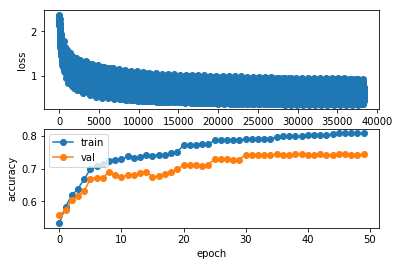

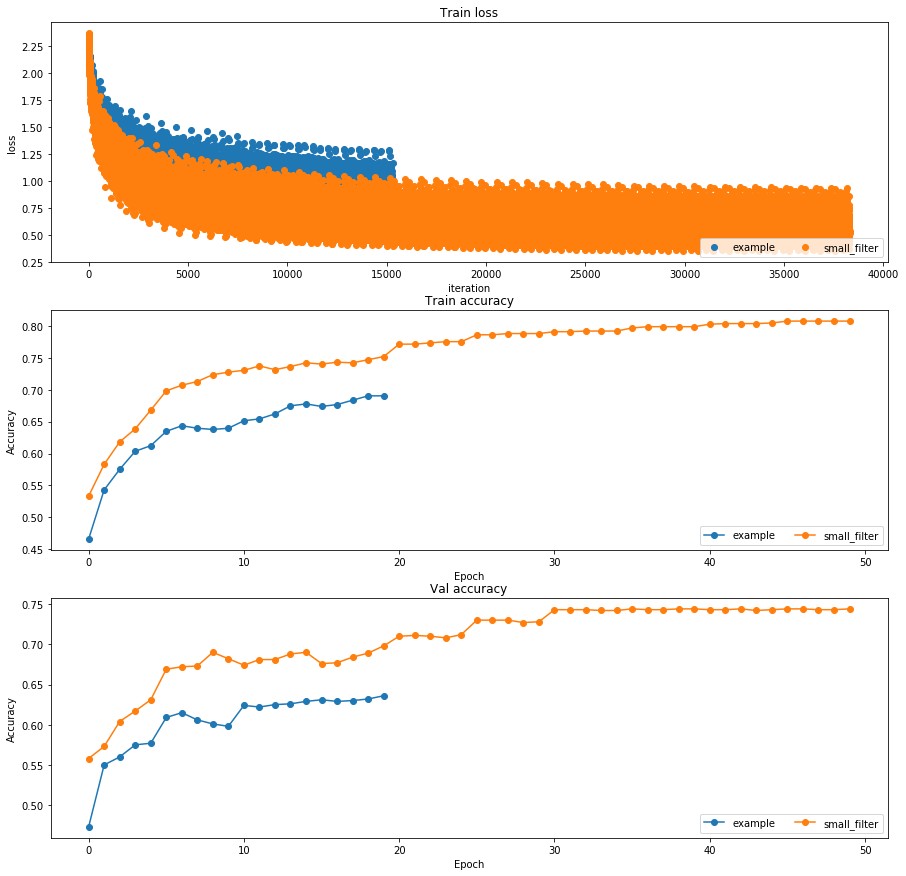

In [67]:
show_solver_training(small_filter_solver)
compare_solvers_tranings({'example': example_solver, 'small_filter': small_filter_solver})
train_stats_copy = (small_filter_solver.loss_history, small_filter_solver.train_acc_history, small_filter_solver.val_acc_history)

### 2.2. small filter cross validation

    lr = 10**np.random.uniform(-5, -2)
    reg = 10**np.random.uniform(-6, -3)
    epochs = 5

val accuracy: 0.680000, train accuracy: 0.721680, final loss: 0.625331, lr: 1.456077e-03, reg: 7.253085e-05
val accuracy: 0.682000, train accuracy: 0.719727, final loss: 0.598466, lr: 1.312655e-03, reg: 7.198197e-04
val accuracy: 0.681000, train accuracy: 0.727539, final loss: 0.544487, lr: 7.749668e-04, reg: 2.428754e-05
val accuracy: 0.674000, train accuracy: 0.704102, final loss: 0.731352, lr: 4.521964e-04, reg: 1.231268e-04
val accuracy: 0.679000, train accuracy: 0.733398, final loss: 0.701049, lr: 3.133872e-03, reg: 5.868976e-06
val accuracy: 0.668000, train accuracy: 0.686523, final loss: 0.995030, lr: 3.618214e-04, reg: 5.506275e-06

-3, -2


In [7]:
torch.cuda.random.manual_seed(12345)

# model
small_filter_model = models.SmallFilterNet().type(dtype)
small_filter_loss_fn = nn.CrossEntropyLoss().type(dtype)

# first, find suitable search range
lr = 5e-5
reg = 1e-6
epochs = 5

small_filter_optimizer = optim.SGD(small_filter_model.parameters(), lr=lr, momentum=0.9, weight_decay=reg)

small_filter_exp_lr_scheduler = None

small_filter_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=small_filter_model,
                                     loss_fn=small_filter_loss_fn,
                                     optimizer=small_filter_optimizer,
                                     scheduler=small_filter_exp_lr_scheduler,
                                     dtype=dtype,
                                     num_epochs=epochs, verbose=True)

small_filter_solver.train()

t = 0, loss = 2.3078


KeyboardInterrupt: 

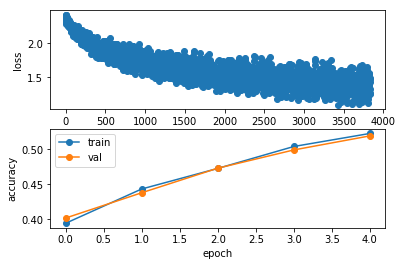

In [27]:
show_solver_training(small_filter_solver)

t = 0, loss = 2.2899
t = 100, loss = 1.4636
t = 200, loss = 1.1034
t = 300, loss = 1.2179
t = 400, loss = 1.1986
t = 500, loss = 1.4134
t = 600, loss = 1.1808
t = 700, loss = 1.1843
(Epoch 0 / 50) train acc: 0.362305; val acc: 0.350000
t = 0, loss = 1.1866
t = 100, loss = 1.0223
t = 200, loss = 0.9646
t = 300, loss = 0.9685
t = 400, loss = 1.0450
t = 500, loss = 1.2829
t = 600, loss = 0.9597
t = 700, loss = 1.0463
(Epoch 1 / 50) train acc: 0.619141; val acc: 0.636000
t = 0, loss = 1.0068
t = 100, loss = 0.9475
t = 200, loss = 0.8815
t = 300, loss = 0.9394
t = 400, loss = 1.0083
t = 500, loss = 1.1644
t = 600, loss = 0.9283
t = 700, loss = 1.1190
(Epoch 2 / 50) train acc: 0.607422; val acc: 0.609000
t = 0, loss = 1.0150
t = 100, loss = 0.9401
t = 200, loss = 0.8165
t = 300, loss = 0.9738
t = 400, loss = 1.0393
t = 500, loss = 1.2505
t = 600, loss = 1.0022
t = 700, loss = 1.0152
(Epoch 3 / 50) train acc: 0.440430; val acc: 0.397000
t = 0, loss = 0.9269
t = 100, loss = 0.8815
t = 200, los

t = 700, loss = 0.7010
(Epoch 34 / 50) train acc: 0.815430; val acc: 0.746000
t = 0, loss = 0.5387
t = 100, loss = 0.5493
t = 200, loss = 0.4967
t = 300, loss = 0.5946
t = 400, loss = 0.5976
t = 500, loss = 0.6921
t = 600, loss = 0.4683
t = 700, loss = 0.7003
(Epoch 35 / 50) train acc: 0.818359; val acc: 0.745000
t = 0, loss = 0.5375
t = 100, loss = 0.5490
t = 200, loss = 0.4960
t = 300, loss = 0.5942
t = 400, loss = 0.5978
t = 500, loss = 0.6909
t = 600, loss = 0.4676
t = 700, loss = 0.6991
(Epoch 36 / 50) train acc: 0.818359; val acc: 0.744000
t = 0, loss = 0.5370
t = 100, loss = 0.5474
t = 200, loss = 0.4948
t = 300, loss = 0.5936
t = 400, loss = 0.5977
t = 500, loss = 0.6913
t = 600, loss = 0.4672
t = 700, loss = 0.6987
(Epoch 37 / 50) train acc: 0.817383; val acc: 0.744000
t = 0, loss = 0.5357
t = 100, loss = 0.5465
t = 200, loss = 0.4951
t = 300, loss = 0.5926
t = 400, loss = 0.5979
t = 500, loss = 0.6907
t = 600, loss = 0.4667
t = 700, loss = 0.6971
(Epoch 38 / 50) train acc: 0.

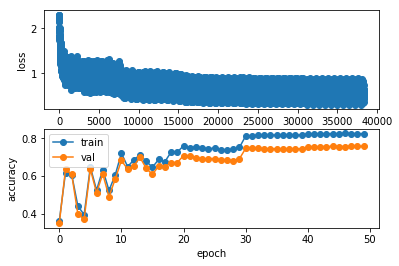

val accuracy: 0.758000, train accuracy: 0.825195, final loss: 0.526698, lr: 3.172417e-03, reg: 3.170000e-02


In [8]:
# good config
# 1. train acc -> 0.95, but vac_acc 0.65
#     lr = 3.172417e-03
#     reg = 1e-5
#     epochs = 50
# small_filter_exp_lr_scheduler = lr_scheduler.StepLR(small_filter_optimizer, step_size=10, gamma=0.5)
#
# * if lr is too small, training is very slow
# * if reg is too large, the train_acc will be low, e.g ~0.8, though avoid overfitting
# * if step_size and gamma is not so good, e.g, step_size=5, gamma=0.5, it may be too urge to annealing learing rate..
#   affected training process.. so, if current lr is ok, keep it for longer?

# 2.
#     reg = 10**np.random.uniform(-6, -3)
#    lr = 3.172417e-03
#    reg = 8.17e-3
#    epochs = 50
#     small_filter_exp_lr_scheduler = lr_scheduler.StepLR(small_filter_optimizer, step_size=10, gamma=0.2)
# * make reg small, then find good lr and lr_scheduler
# * initial lr is good, and lr_scheduler is good, so adjust reg to get good val acc
# * lr_scheduler(s=10, g=0.5) is not good, use(s=5, g=0.5) or (s=10, g=0.2) or (s=20, g=0.1??) will make traniing
# * more stable, loss, acc are more stable
#
# 3.
#    lr = 10**np.random.uniform(-4, -3)
#    reg = 10**np.random.uniform(-6, -3)
#    lr = 3.172417e-03
#    reg = 3.17e-2
#    epochs = 50
#
#     small_filter_exp_lr_scheduler = lr_scheduler.StepLR(small_filter_optimizer, step_size=10, gamma=0.2)
# * enlarge reg to avoid overfiting!
# result: 0.77!
#

import numpy as np

train_stats = {}

# model
small_filter_model = models.SmallFilterNet().type(dtype)
small_filter_loss_fn = nn.CrossEntropyLoss().type(dtype)

max_count = 1
for count in range(max_count):
    lr = 10**np.random.uniform(-4, -3)
    reg = 10**np.random.uniform(-6, -3)
    lr = 3.172417e-03
    reg = 3.17e-2
    epochs = 50
    
    small_filter_model.apply(reset)

    
    small_filter_optimizer = optim.SGD(small_filter_model.parameters(), lr=lr, momentum=0.9, weight_decay=reg)

    small_filter_exp_lr_scheduler = None
    small_filter_exp_lr_scheduler = lr_scheduler.StepLR(small_filter_optimizer, step_size=10, gamma=0.2)
    
    small_filter_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=small_filter_model,
                                     loss_fn=small_filter_loss_fn,
                                     optimizer=small_filter_optimizer,
                                     scheduler=small_filter_exp_lr_scheduler,
                                     dtype=dtype,
                                     num_epochs=epochs, verbose=True)
    small_filter_solver.train()
    
    show_solver_training(small_filter_solver)
    
    train_stats[(lr, reg)] = (small_filter_solver.train_acc_history, small_filter_solver.val_acc_history, small_filter_solver.loss_history)
    print('val accuracy: %f, train accuracy: %f, final loss: %f, lr: %e, reg: %e' % (
        small_filter_solver.val_acc_history[-1], small_filter_solver.train_acc_history[-1], small_filter_solver.loss_history[-1], lr, reg))

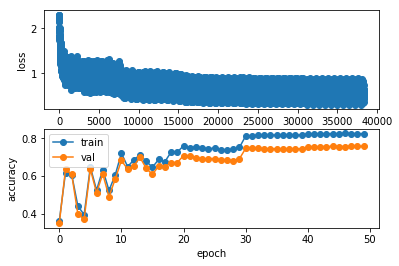

In [9]:
show_solver_training(small_filter_solver)

config1: default one above
config2: fine tuned one, with reg = 8.17e-3
config2: fine tuned one, with reg = 3.17e-2

In [10]:
train_stats_copy3 = (small_filter_solver.loss_history, small_filter_solver.train_acc_history, small_filter_solver.val_acc_history)
views.compare_trainings({"cofig1": train_stats_copy, "config2": train_stats_copy2, "config3": train_stats_copy3})

NameError: name 'train_stats_copy' is not defined

In [ ]:
show_conv_layer_weights()

# 总结

step 0: 寻找一个粗略的lr的区间
* lr的最小值，最大值；reg设置为很小的值，比如1e-6

step 1: cross validation, lr && reg
* reg可设置为e[-6, 6]之间， 然而当reg>1时，效果都不怎么好。所以，主要是寻找lr
* epoch一开始可设置为5, 然后找到好的区间后，可缩小搜索范围，并延长epoch，比如10,20
* 保留一些较好的lr区间或个例，用于进一步搜索。例如，后面寻找好的超参数时，可有多个起点。

step 2: 更长epoch的lr搜索
* 由于一开始的固定lr在多次epoch训练后，逐渐不合适。例如，本来一开始较好的lr，后面可能偏大了，导致loss反而较高，因而需要进行annealing，再去搜索
* 采用step lr schduler，可采用(s=5, g=0.5), (s=10, g=0.2), (s=20, g=0.1)的schduler。多少step后进行调整可以观察下loss什么时候不下降了？
* 有比较合适的lr, lr schduler后，可以观察长些，看看train_acc能否达到0.9以上，说明是一个好的参数（不考虑overfitting)
* 可能会发现，val_acc（以及可能train_acc)在lr schduler影响时（step的节点处），波动很大，那说明过渡不好，比如使用(step=10, gamma=0.5)可能会出现后续几个epoch的lr过大，导致训练loss/acc有断崖出现，换成(s=10, g=0.2)可能更稳定
* 当有好的lr, lr_schduler后，能较好的过拟合数据。虽然过拟合了，但说明参数能够学到训练数据的一些东西，并且模型有足够的容量，且以这样的参数/训练过程，能够把握数据。
* 另一个发现，在消除overfitting时，当慢慢增大reg时，已经配置好的lr, lr_schduler仍然能够稳定的训练，并且达到较高的train_acc。然后，当reg继续增大，且比较合适时。train_acc会降低些，但val_acc已经提升上来，当然loss不一定更低，因为有了reg。